# Libraries

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import yfinance as yf
import pypfopt
import pathlib
import sklearn
import time
import tqdm
from pathlib import Path
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
np.random.seed(1)
print(pypfopt.__version__)
cp.installed_solvers()

1.2.7


['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']

In [2]:
source = Path.cwd() / 'data' / 'quandl'
p = source.glob('*')
files = [x for x in p if x.is_file()]
files

[WindowsPath('F:/graph/small/data/quandl/CRSP US TOTAL MARKET TR INDEX 2011-NOV 2020.xlsx'),
 WindowsPath('F:/graph/small/data/quandl/crsp.xlsx'),
 WindowsPath('F:/graph/small/data/quandl/DAILY.csv'),
 WindowsPath('F:/graph/small/data/quandl/INDICATORS.csv'),
 WindowsPath('F:/graph/small/data/quandl/MSCI US NOV2000 - NOV2020.xlsx'),
 WindowsPath('F:/graph/small/data/quandl/mscius.xlsx'),
 WindowsPath('F:/graph/small/data/quandl/SEP.csv'),
 WindowsPath('F:/graph/small/data/quandl/SF1.csv'),
 WindowsPath('F:/graph/small/data/quandl/SP500.csv'),
 WindowsPath('F:/graph/small/data/quandl/testing_predictions.csv'),
 WindowsPath('F:/graph/small/data/quandl/TICKERS.csv')]

In [3]:
pd.set_option('display.max_columns', 99)
%time crsp = pd.read_excel(source / "crsp.xlsx", skiprows=1, sheet_name = 'Sheet1', engine='openpyxl')
print(crsp.shape)
%time msci = pd.read_excel(source / "mscius.xlsx", skiprows=1, sheet_name="Sheet1", engine="openpyxl")
print(msci.shape)
%time sep = pd.read_csv(source / "SEP.csv", parse_dates=['date'])
print(sep.shape)
%time daily = pd.read_csv(source / "DAILY.csv", parse_dates=['date'])
print(daily.shape)
daily.head()

Wall time: 582 ms
(2435, 2)
Wall time: 336 ms
(5215, 2)
Wall time: 41.9 s
(37383175, 10)
Wall time: 34.1 s
(31666308, 10)


,ticker,date,lastupdated,ev,evebit,evebitda,marketcap,pb,pe,ps
0,A,2018-10-19,2018-10-21,20219.1,20.1,16.7,20551.1,4.5,69.0,4.3
1,AA,2018-10-19,2018-10-21,8037.9,8.4,4.6,7197.9,1.4,50.7,0.6
2,AAL,2018-10-19,2018-10-21,38354.7,10.9,6.9,14754.7,-17.0,9.0,0.3
3,AAMC,2018-10-19,2018-10-21,49.8,-5.7,-6.1,79.1,-0.4,-8.3,4.8
4,AAME,2018-10-19,2018-10-21,83.0,27.1,19.6,56.7,0.6,53.9,0.3


In [4]:
q4_2016 = pd.Timestamp('2016-12-30')
q1_2017 = pd.Timestamp('2017-03-31')
q2_2017 = pd.Timestamp('2017-06-30')
q3_2017 = pd.Timestamp('2017-09-29')
q4_2017 = pd.Timestamp('2017-12-29')
q1_2018 = pd.Timestamp('2018-03-29')
q2_2018 = pd.Timestamp('2018-06-29')
q3_2018 = pd.Timestamp('2018-09-28')
q4_2018 = pd.Timestamp('2018-12-31')
q1_2019 = pd.Timestamp('2019-03-29')
q2_2019 = pd.Timestamp('2019-06-28')
q3_2019 = pd.Timestamp('2019-09-30')

In [5]:
small_tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA"] 

# Helper Functions

In [6]:
from dateutil.relativedelta import relativedelta

# filter out daily DAV of t-1
def one_year_DAV(df, tickers, t):
    '''
    Returns a pd.Series of the one-year Daily Average Volume of given ticker(s) from time t
    
    Parameters:
        df::DataFrame: SEP.csv, with a 'date' DateTime64 column or similar
        tickers::[Strings]: List of strings of names of ticker(s) to get the previous year DAV
        t::pd.Timestamp or similar: Date to filter on
        timedelta::str: 'd, day, days' or 'y, year, years' get DAV of previous day/year
    
    Returns:
        dav::float: average one-year daily volume
    '''
    timedelta = relativedelta(years=1)
    # get range of prev_period to t
    prev_period = t - timedelta
    
    if t not in df['date'].values:
        return 'No data for {t}'.format(t=t)
    
    if not df['ticker'].isin(tickers).any():
        return 'No ticker for any of {tickers}'.format(tickers="tickers")

    if isinstance(df.index, pd.DatetimeIndex):
        mask = (df['ticker'].isin(tickers)) & \
               (df.loc[df.index >= prev_period]) & \
               (df.loc[df.index < t])
    else:
        mask = (df['ticker'].isin(tickers)) & \
               (df['date'] >= prev_period) & \
               (df['date'] < t)
    
    temp_df = df[mask]
    dav = temp_df.groupby('ticker').mean()['volume']
    return dav

In [7]:
print(q2_2017, small_tickers, len(small_tickers))
%time one_year_DAV(sep, small_tickers, q2_2017)

2017-06-30 00:00:00 ['MSFT', 'AMZN', 'KO', 'MA', 'COST', 'LUV', 'XOM', 'PFE', 'JPM', 'UNH', 'ACN', 'DIS', 'GILD', 'F', 'TSLA'] 15
Wall time: 3.33 s


ticker
ACN     2.367280e+06
AMZN    3.552924e+06
COST    2.487783e+06
DIS     7.277147e+06
F       3.697398e+07
GILD    9.803911e+06
JPM     1.547264e+07
KO      1.282638e+07
LUV     6.196298e+06
MA      3.533925e+06
MSFT    2.536449e+07
PFE     2.300750e+07
TSLA    5.012769e+06
UNH     3.442641e+06
XOM     1.144800e+07
Name: volume, dtype: float64

# $\theta_2$ - Time Trend
June 1926 is 1, June 1927 is 2, and so on...

Trading costs have declined over time, Appendix Table A5 show that this decline is largely driven by technological events like moving to decimialization in traded places.

In [8]:
def theta_2(t, coef=0.01):
    '''
    Returns theta_2 * the value of the time_trend, 
    where June 1926 is 1 and July 1926 is 2, ...
    
        Parameters:
            t::pd.Timestamp or similar
            coef::float: Coefficient of the time_trend, defaults to 0.01
        
        Returns:
            diff_in_months::float: coef * time_trend
    '''
    start_time = pd.Timestamp('1926-06-01')
    curr_time = pd.Timestamp(t)
    if curr_time.month >= start_time.month:
        diff_in_years = curr_time.year - start_time.year
    else:
        diff_in_years = curr_time.year - 1 - start_time.year
    #return ( coef * diff_in_years ) # uncomment this line to stop debug
    return diff_in_years

In [9]:
theta_2(q2_2017)

91

# $\theta_3$ - Market Capitalization of stocks
In addition, larger stocks face lower price impact costs, which is also intuitive as the liquidity large stocks is typically much greater than for smaller stocks. A large trade size in illiquid stocks will result in much larger transaction costs, consistent with both literature Kyle (1985) and many empirical estimates Hasbrouck (2009).

In [10]:
def theta_3(df, tickers, t, coef=-0.14):
    '''
    Returns theta_3 * log(1 + market cap of equity (USD Billions))

        Parameters:
            df:DataFrame: DAILY.csv, with a 'date' DateTime64 column or similar
            tickers::[Strings]: List of strings of names of ticker(s) to get the previous year DAV
            t::pd.Timestamp or similar: Date to filter on

        Returns:
            ans::float: log ( 1 + market cap of equity (in billions of USD))

    '''
    timedelta = relativedelta(days=1)
    # get range of prev_period to t
    prev_period = t - timedelta

    if prev_period not in df['date'].values:
        print(prev_period, 'not available')
        # This is a catch for long weekends/holidays where there is no available data
        for i in range(4):
            prev_period = prev_period - relativedelta(days = 1)
            if prev_period in df['date'].values:
                print("found data for prev_period:", prev_period)
                break
    print('\nnew prev_period:', prev_period)

    if ~df['ticker'].isin(tickers).any():
        return 'No ticker for any of {tickers}'.format(tickers="tickers")

    mask = (df['ticker'].isin(tickers)) & (df['date'] == prev_period)

    temp_df = df[mask].drop_duplicates()
    market_value_of_equity = pd.Series(index = temp_df['ticker'], 
                           data = (temp_df[['marketcap']].values/1000).flatten(), 
                           name = 'marketcap')
    market_value_of_equity.fillna(1e-5, inplace=True)
    #print("market_cap\n", market_value_of_equity)
    tickers_series = pd.Series(data=tickers, name='tickers')
    #print("tickers\n", tickers_series)
    temp = pd.merge(market_value_of_equity, tickers_series, left_index=True, right_on='tickers', how='inner').drop_duplicates()
    market_value_of_equity = pd.Series(data = temp['marketcap'].values, index=temp['tickers'], name='market_value_of_equity', dtype='float64')

    if len(market_value_of_equity) < len(tickers_series):
        print("Theta_3: {tickers} Market Cap not returning properly".format(tickers = set(tickers) ^ set(market_value_of_equity.index)))

        missing_tickers = list(set(tickers) ^ set(market_value_of_equity.index))
        marketcap_missing_tickers = []
        for ticker in missing_tickers:
            marketcap_missing_tickers.append(yf.Ticker(ticker).info['marketCap'] / 1000000000)

        missing_data = pd.Series(data=marketcap_missing_tickers, index=missing_tickers, name='marketcap_missing_tickers')
        market_value_of_equity = pd.concat([market_value_of_equity, missing_data], axis=0)
    #market_value_of_equity.drop_duplicates(inplace=True)
    try:
        ans = np.log(1 + market_value_of_equity)
        return ( ans * coef )
    except TypeError:
        print('\n')
        print("Check market_cap function returns a float")

In [11]:
%time theta_3(daily, small_tickers, q2_2017, coef=-0.14)


new prev_period: 2017-06-29 00:00:00
Wall time: 2.5 s


tickers
ACN    -0.622365
AMZN   -0.860627
COST   -0.595976
DIS    -0.716035
F      -0.534414
GILD   -0.635456
JPM    -0.809666
KO     -0.736442
LUV    -0.510634
MA     -0.682788
MSFT   -0.878144
PFE    -0.742948
TSLA   -0.573806
UNH    -0.726654
XOM    -0.817261
Name: market_value_of_equity, dtype: float64

In [12]:
prev_period = q2_2017 - relativedelta(days=1)
mask = ( daily['ticker'].isin(small_tickers) ) & ( daily['date'] == prev_period)
marketcap = daily[mask].set_index('ticker')['marketcap']
marketcap / 1000

ticker
ACN      84.2394
AMZN    466.4706
COST     69.5960
DIS     165.4234
F        44.4788
GILD     92.5948
JPM     323.8381
KO      191.5388
LUV      37.3742
MA      130.2442
MSFT    528.7781
PFE     200.6986
TSLA     59.2567
UNH     178.5376
XOM     341.9473
Name: marketcap, dtype: float64

In [13]:
np.log(1 + marketcap / 1000) * -0.14

ticker
ACN    -0.622365
AMZN   -0.860627
COST   -0.595976
DIS    -0.716035
F      -0.534414
GILD   -0.635456
JPM    -0.809666
KO     -0.736442
LUV    -0.510634
MA     -0.682788
MSFT   -0.878144
PFE    -0.742948
TSLA   -0.573806
UNH    -0.726654
XOM    -0.817261
Name: marketcap, dtype: float64

# $\theta_4$ / $\theta_5$ - Trade Size as a Fraction of Daily Average Volume/Sqrt(Fraction of DAV) 
Size of Trade as Fraction of Daily Average Volume  
Size of Trade as $ \sqrt{ \text{Fraction of Daily Average Volume} } $

Larger trades have higher transaction costs, consistent with price impact and trading cost models such as Kyle (1985), and the live trading data from AQR's own trades as a function of trade size, measured by the fraction of daily trading volume traded.
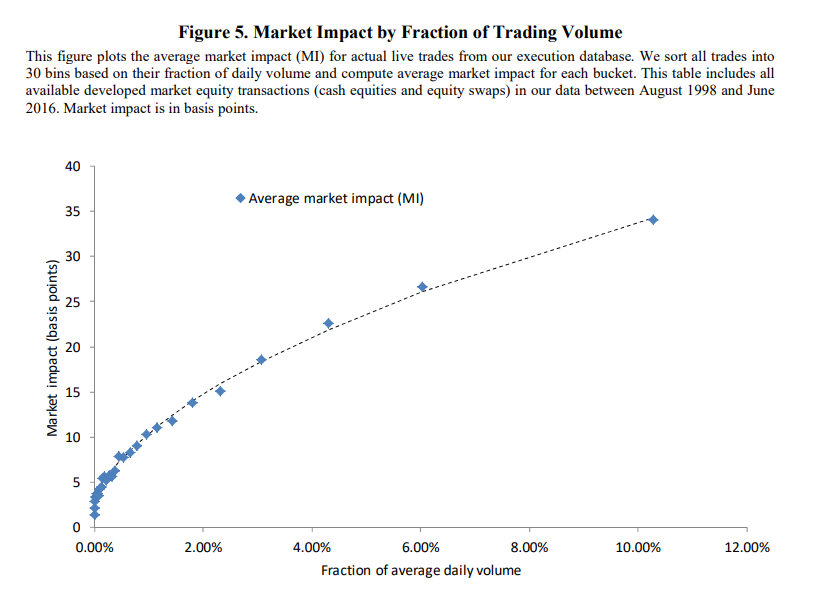
The figure shows a concave relation between market impact and trade size, with costs growing significantly at very large sizes in percentage of DTV, but at a decreasing rate

In [14]:
mask = sep['date'] == prev_period
prev_sep = sep[mask]
print(prev_sep.shape)
mask = sep['date'] == q2_2017
curr_sep = sep[mask]
print(curr_sep.shape)

(6501, 10)
(6505, 10)


In [15]:
np.random.seed(1)
test_prev_df = pd.DataFrame(data = small_tickers, columns=['ticker'])
test_prev_df['long'] = np.random.choice([1,-1], size=test_prev_df.shape[0])
test_prev_df = pd.merge(test_prev_df, prev_sep[['ticker', 'close']], on='ticker', how='inner')
test_prev_df.rename(columns={'close':'price'}, inplace=True)
test_prev_df['shares'] = np.round( np.random.randint(low=0, high=150000, size=test_prev_df.shape[0]) * test_prev_df['long'] )
test_prev_df.head()

,ticker,long,price,shares
0,MSFT,-1,68.49,-31228
1,AMZN,-1,975.93,-21758
2,KO,1,44.83,51668
3,MA,1,121.51,139516
4,COST,-1,158.68,-19946


In [16]:
test_curr_df = pd.DataFrame(data = small_tickers, columns=['ticker'])
test_curr_df['long'] = np.random.choice([1,-1], size=test_curr_df.shape[0])
test_curr_df = pd.merge(test_curr_df, curr_sep[['ticker', 'close']], on='ticker', how='inner')
test_curr_df.rename(columns={'close':'price'}, inplace=True)
dav = one_year_DAV(sep, small_tickers, q2_2017)
pct_of_dav = dav * 0.1
test_curr_df = pd.merge(test_curr_df, pct_of_dav, left_on='ticker', right_index=True, how='inner')
test_curr_df['shares'] = np.round(test_curr_df['volume'] * test_curr_df['long'])
test_curr_df.head()

,ticker,long,price,volume,shares
0,MSFT,-1,68.93,2.536449e+06,-2536449.0
1,AMZN,1,968.00,3.552924e+05,355292.0
2,KO,-1,44.85,1.282638e+06,-1282638.0
3,MA,-1,121.45,3.533925e+05,-353392.0
4,COST,1,159.93,2.487783e+05,248778.0


In [17]:
def theta_4_and_5(df, tickers, t, curr_df, prev_df, coef=(-0.53, 11.21)):
    '''
    Returns theta_4, theta_5: (Fraction of Daily Volume of the Trade, Sqrt(Fraction of Daily Volume of Trade)
    
    ====================== Need to figure out how to pass prev_df =============================
    
    Parameters:
        df::DataFrame: SEP.csv, with a Datetime64 'date' column
        tickers::[Strings]: List of strings of names of ticker(s) to get the previous year DAV
        t::pd.Timestamp or similar:
        curr_df::DataFrame: Current DataFrame with a 'long'(bool), 'price', 'shares' column
        prev_df::DataFrame: Previous DataFrame with a 'long'(bool), 'price', 'shares' column 
        coef::float: coefficient in Table VIII

    Returns:
        Fraction of daily volume: coef * Trade's dollar size / stock's 1-year DAV (in %)
    '''
    davs = one_year_DAV(df, tickers, t)

    temp_df = pd.merge(davs, prev_df, left_index=True, right_on='ticker', how='inner')
    temp_df = pd.merge(temp_df, curr_df.set_index('ticker')[['long', 'shares', 'price']], left_on='ticker', right_index=True,
                      how='inner', suffixes=("_prev", "_curr"))
    #print(temp_df.shape)

    size_of_trades = np.zeros(len(temp_df))
    
    for i in range(len(temp_df)):
            new_shares = temp_df.iloc[i]['shares_curr'] - temp_df.iloc[i]['shares_prev']
            size_of_trades[i] = new_shares * temp_df.iloc[i]['price_curr']

    size_of_trade = pd.Series(data = size_of_trades, index = temp_df['ticker'], name = 'size_of_trade')

    temp_df = pd.merge(temp_df, size_of_trade, left_on='ticker', right_index=True, how='inner')
    temp_df['frac_of_daily_volume'] = np.where(temp_df['size_of_trade'] != 0, temp_df['size_of_trade'] / temp_df['volume'], 0)
    temp_df['sqrt_of_frac_of_daily_volume'] = np.sqrt(np.abs(temp_df['frac_of_daily_volume']))
    
    temp_df.sort_index(inplace=True)
    temp_df.set_index('ticker', inplace=True)
    theta_4 = coef[0] * temp_df['frac_of_daily_volume'] 
    theta_5 = coef[1] * temp_df['sqrt_of_frac_of_daily_volume']
    
    # return theta_4, theta_5 # uncomment this line to stop debug
    return temp_df

In [18]:
%time theta_4_and_5(sep, small_tickers, q2_2017, test_curr_df, test_prev_df)

Wall time: 3.11 s


,volume,long_prev,price_prev,shares_prev,long_curr,shares_curr,price_curr,size_of_trade,frac_of_daily_volume,sqrt_of_frac_of_daily_volume
ticker,,,,,,,,,,
MSFT,2.536449e+07,-1,68.49,-31228,-1,-2536449.0,68.93,-1.726849e+08,-6.808136,2.609240
AMZN,3.552924e+06,-1,975.93,-21758,1,355292.0,968.00,3.649844e+08,102.727904,10.135478
KO,1.282638e+07,1,44.83,51668,-1,-1282638.0,44.85,-5.984362e+07,-4.665667,2.160016
MA,3.533925e+06,1,121.51,139516,-1,-353392.0,121.45,-5.986368e+07,-16.939714,4.115788
COST,2.487783e+06,-1,158.68,-19946,1,248778.0,159.93,4.297703e+07,17.275232,4.156348
LUV,6.196298e+06,-1,61.81,-103068,1,619630.0,62.14,4.490845e+07,7.247626,2.692142
XOM,1.144800e+07,-1,80.70,-92740,-1,-1144800.0,80.73,-8.493280e+07,-7.419007,2.723785
PFE,2.300750e+07,-1,33.63,-31959,1,2300750.0,33.59,7.835570e+07,3.405659,1.845443
JPM,1.547264e+07,-1,91.15,-148209,1,1547264.0,91.40,1.549662e+08,10.015501,3.164728


# $\theta_6: \sigma^{IV}$ and $\theta_7: \text{VIX}$ - Idiosyncratic Volatility and VIX
Idiosyncratic Volatility is directly tied to beta, which is a measure of a given investment's fluctuations (volatility) are larger or smaller than that of the benchmark (index)

Market's Level of Volatility (VIX) is measured by the monthly variance of the CRSP value weighted index representing the market's expectations for volatility over the coming 30 days. Investors use VIX to measure the level of risk, fear, or stress in the market when making investment decisions.

More volatile firms have higher transaction costs, consistent with models of market maker inventory risk, and more volatile market environments are also associated with larger price impact costs, consistent with market makers needing to be compensated more in more volatile markets.

In [19]:
def theta_6(df, benchmark, tickers, t, coef=0.31):
    '''
    Returns a pd.Series of coef * idiosyncratic volatility of stocks
    
    It is calculated by regressing one-year daily stock returns against the MSCI-US benchmark, 
    then the idiosyncratic volatility is the standard deviation of the residuals 
    
    Parameters:
        df::DataFrame: SEP.csv with a 'Date' DateTime64 column or similar
        benchmark::DataFrame: mscius.xlsx with 'Exchange Date' DateTime64 column and 'Close' column
        tickers::[Strings]: List of strings of names of ticker(s) to get the previous year DAV
        t::pd.Timestamp or similar: Date to filter on
        coef::float: theta_6 value
    
    Returns:
        ans::float: Idiosyncratic Volatility of regression of one-year daily stock returns on MSCI-US
    
    benchmark = alpha + beta * instrument returns + residuals
    
    Calculates the idiosyncratic volatility of a stock, which measures
    how much an investment's price fluctuates around relative
    to its relationship to a benchmark. 
    
    It is directly tied to beta, which is a measure of whether
    a given investment's fluctuations are larger or smaller
    than that of another index. 
    '''
    from sklearn.linear_model import LinearRegression
       
    prev_period = t - relativedelta(years=1)
    
    #mask = (df['ticker'].isin(tickers)) & (df['date'] >= prev_period) & (df['date'] < t)
    mask = (df['ticker'].isin(tickers)) & (df['date'] == prev_period)
    if df[mask].shape[0] < 1:
        print('No data for {t} in Data'.format(t=prev_period))
    for i in range(4):
        prev_period = prev_period - relativedelta(days = 1)
        mask = (df['date'] == prev_period) & (df['ticker'].isin(tickers))
        if df[mask].shape[0] == len(tickers):
            print("found new prev_period with all data:", prev_period)
            break
        
    print('\nNew prev_period', prev_period, 't', t)
    mask = (df['ticker'].isin(tickers)) & (df['date'] >= prev_period) & (df['date'] < t)
    prices_df = df[mask].sort_values('date', axis=0, ascending=True, ignore_index=True)
    prices_df['returns'] = prices_df.groupby(['ticker'])['close'].pct_change()
    returns_df = prices_df[['date', 'ticker', 'returns']].set_index('date').fillna(0)
    #print('returns_df', returns_df)
    
    mask = (benchmark.iloc[:,0] >= prev_period) & (benchmark.iloc[:,0] < t)
    if benchmark[mask].shape[0] < 1:
        return 'No data for {t} in {df}'.format(t=t, df=df)
    benchmark_df = benchmark[mask].sort_values('Exchange Date', axis=0, ascending=True, ignore_index=True).set_index('Exchange Date')
    benchmark_df = benchmark_df['Close'].pct_change().fillna(0)
    #print("benchmark_df", benchmark_df)
    volatility_df = pd.merge(returns_df, benchmark_df, how='inner', left_index=True, right_index=True, validate='m:1')
    #print("volatility_df", volatility_df)
    idiosyncratic_volatility_list = []
    for ticker in tickers:
        mask = volatility_df['ticker'] == ticker
        X = volatility_df[mask]['returns'].values.reshape(-1,1)
        y = volatility_df[mask]['Close'].values
        model = LinearRegression()
        model.fit(X, y)
        preds = model.predict(X)
        residuals = preds - y
        idiosyncratic_volatility_list.append( np.std(residuals, ddof=1) )

    idiosyncratic_volatility = pd.Series(data=idiosyncratic_volatility_list, index=tickers, name="idiosyncratic_volatility")
    #idiosyncratic_volatility.drop_duplicates(inplace=True)
    
    #return ( idiosyncratic_volatility * coef ) # uncomment this line to stop debug
    return idiosyncratic_volatility

Let's find the idiosyncratic of an individual stock `MSFT` manually.  

Regress one-year daily stock returns against the benchmark of your choice.  Then the idiosyncratic volatility is the standard deviation of the residuals, which is a measure of how much an investment price fluctuates around, relative to its relationship to the benchmark. 

In [20]:
prev_year = q2_2017 - relativedelta(years = 1)
mask = (sep['ticker'].isin(small_tickers)) & (sep['date'] >= prev_year) & (sep['date'] < q2_2017)
print(sep[mask].shape)
# returns for the year
prices_df = sep[mask].sort_values('date', axis=0, ascending=True, ignore_index=True)
prices_df['returns'] = prices_df.groupby(['ticker'])['close'].pct_change().fillna(0)
print(prices_df.shape)
prices_df.head()

(3780, 10)
(3780, 11)


,ticker,date,open,high,low,close,volume,dividends,closeunadj,lastupdated,returns
0,XOM,2016-06-30,92.33,93.827,92.30,93.74,14073677.0,0.0,93.74,2018-06-13,0.0
1,ACN,2016-06-30,112.32,113.310,112.11,113.29,3682559.0,0.0,113.29,2018-06-13,0.0
2,AMZN,2016-06-30,717.20,719.370,712.54,715.62,2855142.0,0.0,715.62,2018-06-13,0.0
3,COST,2016-06-30,156.96,157.820,155.50,157.04,3091123.0,0.0,157.04,2018-06-13,0.0
4,DIS,2016-06-30,97.10,98.070,96.88,97.82,7189489.0,0.0,97.82,2018-06-13,0.0


In [21]:
# returns for all the tickers
returns_df = prices_df[['date', 'ticker', 'returns']].set_index('date').fillna(0)
print(returns_df.shape)
# returns for MSFT
mask = returns_df['ticker'] == 'MSFT'
returns_msft = returns_df[mask]
print(returns_msft.shape)
# returns for the benchmark
mask = (msci.iloc[:,0] >= prev_year) & (msci.iloc[:,0] < q2_2017)
benchmark_df = msci[mask].sort_values('Exchange Date', axis=0, ascending=True, ignore_index=True).set_index('Exchange Date')
benchmark_df = benchmark_df['Close'].pct_change().fillna(0)
print(benchmark_df.shape)
# merge both of the dataframes
volatility_df = pd.merge(returns_msft, benchmark_df, how='inner', left_index=True, right_index=True, validate='m:1')
volatility_df.head()

(3780, 2)
(252, 2)
(261,)


,ticker,returns,Close
2016-06-30,MSFT,0.000000,0.000000
2016-07-01,MSFT,-0.000195,0.002064
2016-07-05,MSFT,0.000195,-0.007010
2016-07-06,MSFT,0.004104,0.005414
2016-07-07,MSFT,0.000000,-0.000549


In [22]:
X = volatility_df['returns'].values.reshape(-1,1)
y = volatility_df['Close'].values
print(X.shape, y.shape)

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
preds = model.predict(X)
residuals = preds - y
np.std(residuals, ddof=1)

(252, 1) (252,)


0.004098025160819627

In [23]:
%time theta_6(sep, msci, small_tickers, q2_2017, coef=0.31)

found new prev_period with all data: 2016-06-29 00:00:00

New prev_period 2016-06-29 00:00:00 t 2017-06-30 00:00:00
Wall time: 4.84 s


MSFT    0.004130
AMZN    0.004519
KO      0.004686
MA      0.004393
COST    0.004985
LUV     0.004703
XOM     0.004646
PFE     0.004697
JPM     0.004177
UNH     0.004756
ACN     0.004668
DIS     0.004692
GILD    0.004932
F       0.004488
TSLA    0.004996
Name: idiosyncratic_volatility, dtype: float64

We take the sample median of the CRSP-value weighted index, computed using daily returns (annualized %), to measure the Market Level of Volatility (VIX)

In [24]:
def theta_7(crsp, t, coef=0.12):
    '''
    Returns theta_7 * monthly variance of CRSP-value weighted index    

    Parameters:
        df:DataFrame: CRSP-Value Index with a DateTime64 first column or similar
        coef::float: theta_7 value
        t::pd.Timestamp or similar: Date to filter on

    Returns:
        ans::float: Sample monthly variance of CRSP-Value Weighted Index
    '''

    past_month = t - relativedelta(months=1)
    mask = (crsp.iloc[:,0] >= past_month) & (crsp.iloc[:,0] < t)
    if crsp[mask].shape[0] < 1:
        return 'No data for {t}'.format(t=t)
    vix_values = crsp[mask].iloc[:,1].pct_change().fillna(0)
    # vix = np.var(crsp_values, ddof=1)
    vix = np.median(vix_values)
    #return ( vix * coef ) # uncomment this to stop debug
    return vix_values

In [25]:
prev_month = q2_2017 - relativedelta(months=1)
crsp['returns'] = crsp['Close'].pct_change().fillna(0)
mask = (crsp.iloc[:,0] >= prev_month) & (crsp.iloc[:,0] < q2_2017)
vix_values = crsp[mask]['Close'].pct_change().fillna(0)
vix_values

1551    0.000000
1552   -0.000123
1553    0.009208
1554    0.003828
1555   -0.001856
1556   -0.002747
1557    0.001537
1558    0.001603
1559   -0.000483
1560   -0.000825
1561    0.005217
1562   -0.001453
1563   -0.002496
1564    0.000073
1565    0.008210
1566   -0.007146
1567   -0.000882
1568    0.000102
1569    0.002468
1570    0.000676
1571   -0.008342
1572    0.009702
1573   -0.008405
Name: Close, dtype: float64

In [26]:
%time theta_7(crsp, q2_2017, coef=0.12)

Wall time: 5.07 ms


1551    0.000000
1552   -0.000123
1553    0.009208
1554    0.003828
1555   -0.001856
1556   -0.002747
1557    0.001537
1558    0.001603
1559   -0.000483
1560   -0.000825
1561    0.005217
1562   -0.001453
1563   -0.002496
1564    0.000073
1565    0.008210
1566   -0.007146
1567   -0.000882
1568    0.000102
1569    0.002468
1570    0.000676
1571   -0.008342
1572    0.009702
1573   -0.008405
Name: Close, dtype: float64

# Market Impact Model
The econometric causal model to measure the expected trading cost of a portfolio out of sample in Frazzini et al (2018) is a function of the amount traded in the form:

$$
MI = a + b\cdot x + c \cdot sign(x) \sqrt{|x|}
$$

Where:

$a = \theta_2 \bar{time trend} + \theta_3 \bar{log(1 + market cap)} + \theta_6 \bar{sigma^{IV}} + \theta_7 \bar{VIX}$, evaluated at the sample medians of respective variables. $a$ controls for the general level of trading costs on aspects that do not dependent on trade size.  
$b = \theta_4$ and $c = \theta_5$ are variables that measure the trade size as a variable of the daily average volume.


This follows common transaction cost models in literature, in:
**INSERT THE TWO REFERENCE ON TRANSACTION COSTS HERE (CVXPORTFOLIO PAPER AND THE PORTFOLIO CONSTRUCTION TEXTBOOK**

In [58]:
def market_impact(daily, sep, benchmark, vix, list_of_tickers, currdf, prevdf, t):
    """
        Returns the market impact of a trade on the market

            Parameters:
                daily::pd.DataFrame: DAILY.csv
                sep::pd.DataFrame: SEP.csv
                benchmark::pd.DataFrame: mscius.xlsx ('Exchange Date', 'Close')
                crsp::pd.DataFrame: crsp.xlsx ('Exchange Date', Close')
                ticker::[Strings]: List of strings of names of ticker(s)
                t::pd.Timestamp: Date of rebalance
                currdf::DataFrame: Current DataFrame with a 'long'(bool), 'price', 'shares' column
                prevdf::DataFrame: Previous DataFrame with a 'long'(bool), 'price', 'shares' column 


            Returns:
                market_impact::float: Estimated Market Impact of the trade   

        Market Impact Model uses estimated coefficients from Table VII of Frazzini et al - Trading Costs (2018)
        Column (5) for a Global sample, Column (10) for US sample, Column (15) for International

        MI = a + b*x + c*sign(x)*sqrt( abs(x) )
        x = m/dtv*100%, where m = sign(dollar volume) and dtv =  stock's average one year dollar volume
        dollar volume: total value of shares traded = volume * price
        
    """
    #print(list_of_tickers)
    # Theta_2: Time trend
    theta_2 = -0.01
    
    start_time = pd.Timestamp('1926-06-01')
    curr_time = pd.Timestamp(t)
    if curr_time.month >= start_time.month:
        diff_in_years = curr_time.year - start_time.year
    else:
        diff_in_years = curr_time.year - 1 - start_time.year
    
    theta2 = theta_2 * diff_in_years
    
    # Theta_3: Log (1 + market cap)
    theta_3 = -0.14
    timedelta = relativedelta(days=1)
    # get range of prev_period to t
    prev_period = t - timedelta
    
    if prev_period not in daily['date'].values:
        #print(prev_period, 'not available')
        # This is a catch for long weekends/holidays where there is no available data
        for i in range(4):
            prev_period = prev_period - relativedelta(days = 1)
            if prev_period in daily['date'].values:
                print("Theta_3: found data for prev_period:", prev_period)
                break
    #print('\nTheta_3 new prev_period:', prev_period)
    
    if ~daily['ticker'].isin(list_of_tickers).any():
        return 'Theta_3: No ticker for any of {tickers}'.format(tickers="tickers")
       
    mask = (daily['ticker'].isin(list_of_tickers)) & (daily['date'] == prev_period)
    
    temp_df = daily[mask].drop_duplicates()
    market_value_of_equity = pd.Series(index = temp_df['ticker'], 
                           data = (temp_df[['marketcap']].values/1000).flatten(), 
                           name = 'marketcap', dtype='float64')
    market_value_of_equity.fillna(1e-5, inplace=True)
    #print("market_cap\n", market_value_of_equity)
    tickers_series = pd.Series(data=list_of_tickers, name='tickers')
    #print("tickers\n", tickers_series)    
    temp = pd.merge(market_value_of_equity, tickers_series, left_index=True, right_on='tickers', how='inner').drop_duplicates()
    market_value_of_equity = pd.Series(data = temp['marketcap'].values, index=temp['tickers'], name='market_value_of_equity', dtype='float64')
    
    if len(market_value_of_equity) < len(list_of_tickers) and len( set(list_of_tickers) ^ set(market_value_of_equity.index) ) > 0:
        print("Theta_3: {tickers} data not available in DAILY.csv".format(tickers = set(list_of_tickers) ^ set(market_value_of_equity.index)))
 
        missing_tickers = list(set(list_of_tickers) ^ set(market_value_of_equity.index))
        marketcap_missing_tickers = []
        # Download the latest market cap from Yahoo Finance
        for ticker in missing_tickers:
            marketcap_missing_tickers.append(yf.Ticker(ticker).info['marketCap'] / 1000000000)

        missing_data = pd.Series(data=marketcap_missing_tickers, index=missing_tickers, name='marketcap_missing_tickers', dtype='float64')
        market_value_of_equity = pd.concat([market_value_of_equity, missing_data], axis=0) 

    try:
        ans = np.log(1 + market_value_of_equity)
    except TypeError:
        print('\n')
        print("Theta_3: Check market_cap function returns a float")
    theta3 = ans * theta_3
    
    # Theta_4 and Theta_5: Fraction of Daily Volume and Sqrt(Fraction of Daily Volume)
    theta_4, theta_5 = -0.53, 11.21
    
    timedelta = relativedelta(years=1)
    # get range of prev_period to t
    try:
        prev_period = t - timedelta
    except:
        print("Theta_4_5: t is not a Datetime", t)
    #print(list_of_tickers)
    mask = (sep['ticker'].isin(list_of_tickers)) & (sep['date'] == prev_period)
    if sep[mask].shape[0] < 1:
        #print('Theta_4_5_6:No data for {t} in Data'.format(t=prev_period))
        for i in range(4):
            prev_period = prev_period - relativedelta(days = 1)
            mask = (sep['date'] == prev_period) & (sep['ticker'].isin(list_of_tickers))
            if sep[mask].shape[0] == len(list_of_tickers):
                print("Theta_4_5_6: found new prev_period with all data:", prev_period)
                break
        
    print('\nNew prev_period', prev_period, 't', t)

    if t not in sep['date'].values:
        return 'Theta_4, Theta_5:No data for {t}'.format(t=t)
    
    if not sep['ticker'].isin(list_of_tickers).any():
        return 'Theta_4, Theta_5: No ticker for any of {tickers}'.format(tickers="tickers")
    
    mask = (sep['ticker'].isin(list_of_tickers)) & \
           (sep['date'] >= prev_period) & \
           (sep['date'] < t)
    
    temp_df = sep[mask]
    
    # Theta_6: Idiosyncratic Volatility
    # uses the same dataframe as Theta_4 and Theta_5 so I put it here for efficiency
    theta_6 = 0.31
    if temp_df.shape[0] < 1:
        return 'Theta_6: No data for {t} in data'.format(t=t)
    prices_df = temp_df.sort_values('date', axis=0, ascending=True, ignore_index=True)
    prices_df['returns'] = prices_df.groupby(['ticker'])['close'].pct_change()
    returns_df = prices_df[['date', 'ticker', 'returns']].set_index('date').fillna(0)

    mask = (benchmark.iloc[:,0] >= prev_period) & (benchmark.iloc[:,0] < t)
    if benchmark[mask].shape[0] < 1:
        return 'Theta_6: No data for {t} in data'.format(t=t)
    benchmark_df = benchmark[mask].sort_values('Exchange Date', axis=0, ascending=True, ignore_index=True).set_index('Exchange Date')
    benchmark_df = benchmark_df['Close'].pct_change().fillna(0) # Close is now returns
    volatility_df = pd.merge(returns_df, benchmark_df, how='inner', left_index=True, right_index=True, validate='m:1')
  
    idiosyncratic_volatility_list = []
    for ticker in list_of_tickers:
        mask = volatility_df['ticker'] == ticker
        X = volatility_df[mask]['returns'].values.reshape(-1,1)
        y = volatility_df[mask]['Close'].values
        model = LinearRegression()
        model.fit(X, y)
        preds = model.predict(X)
        residuals = preds - y
        idiosyncratic_volatility_list.append( np.std(residuals, ddof=1) )

    idiosyncratic_volatility = pd.Series(data=idiosyncratic_volatility_list, index=list_of_tickers, name="idiosyncratic_volatility", dtype='float64')
    idiosyncratic_volatility.drop_duplicates(inplace=True)
    theta6 = theta_6 * idiosyncratic_volatility
    
    # Theta_4 and Theta_5: Fraction of Trade of 1-year Daily Average Volume
    
    davs = temp_df.groupby('ticker').mean()['volume']

    temp_df = pd.merge(davs, prevdf, left_index=True, right_on='ticker', how='inner')
    temp_df = pd.merge(temp_df, currdf.set_index('ticker')[['long', 'shares', 'price']], left_on='ticker', right_index=True,
                      how='inner', suffixes=("_prev", "_curr"))
    #temp_df.drop_duplicates(inplace=True) # not sure if this affects anything if error remove this comment

    size_of_trades = np.zeros(len(temp_df))
    
    for i in range(len(temp_df)):
        new_shares = temp_df.iloc[i]['shares_curr'] - temp_df.iloc[i]['shares_prev']
        size_of_trades[i] = new_shares * temp_df.iloc[i]['price_curr']

    size_of_trade = pd.Series(data = size_of_trades, index = temp_df['ticker'], name = 'size_of_trade', dtype='float64')

    temp_df = pd.merge(temp_df, size_of_trade, left_on='ticker', right_index=True, how='inner')
    temp_df['frac_of_daily_volume'] = np.where(temp_df['size_of_trade'] != 0,  temp_df['size_of_trade'] / temp_df['volume'], 0)
    temp_df['sqrt_of_frac_of_daily_volume'] = np.sqrt(np.abs(temp_df['frac_of_daily_volume']))
    
    temp_df.sort_index(inplace=True)
    temp_df.set_index('ticker', inplace=True)
    theta4 = theta_4 * temp_df['frac_of_daily_volume'] 
    theta5 = theta_5 * temp_df['sqrt_of_frac_of_daily_volume']
    
    # Theta_7
    theta_7 = 0.12
    
    prev_period = t - relativedelta(months=1)
    mask = (vix.iloc[:,0] >= prev_period) & (vix.iloc[:,0] < t)
    if vix[mask].shape[0] < 1:
        return 'No data for {t}'.format(t=t)
    vix_values = vix[mask].iloc[:,1].pct_change().fillna(0)
    
    theta7 = theta_7 * vix_values
    
    a = theta2 + np.median(theta3) + np.median(theta6) + np.median(theta7)
    #a = np.median(theta3) + np.median(theta6) + np.median(theta7)
    b = theta4
    c = theta5
    marketimpact = a + b + c
    #print('\ntheta_2', theta2, '\ntheta3\n', theta3, '\ntheta4\n', theta4, '\ntheta5\n', theta5, '\ntheta6\n', theta6, '\ntheta7\n', theta7, '\n')
    return marketimpact

# Market Impact Analysis

In [29]:
preds = pd.read_csv(source / "testing_predictions.csv")
preds.head()

,ground_truth,ensemble_prediction,year-quarter,ticker
0,0.108104,0.041631,2017-1,A
1,0.080545,-0.000002,2017-2,A
2,0.035960,0.008540,2017-3,A
3,-0.041697,0.018393,2017-4,A
4,-0.094635,-0.068808,2018-1,A


In [30]:
prev_period = q2_2018 - relativedelta(years=1)
mask = sep['date'] == prev_period
prev_sep = sep[mask]
print(prev_sep.shape)
mask = sep['date'] == q2_2018
curr_sep = sep[mask]
print(curr_sep.shape)

(6501, 10)
(6571, 10)


In [31]:
def get_dataframe(df, quarter='2017-1'):
    '''
    Filters the predictions from the ensemble for specific quarter
    Parameters:
        df::pd.DataFrame: testing_predictions.csv or preds
        quarter::str: in the format: YYYY-Q
        2017-1 refers to 2017, Q1 predictions 
    Returns: 
        DataFrame
    '''
    mask = df['year-quarter'].values == quarter
    temp_df = df[mask].reset_index(drop=True)
    temp_df.rename(columns={"ground_truth": "y", "ensemble_prediction": "y_pred"}, inplace=True)
    return temp_df
q1_2018_preds = get_dataframe(preds, quarter='2018-1')
q3_2018 = get_dataframe(preds, '2018-3')

In [32]:
tickers = q1_2018_preds['ticker'].unique().tolist()
print(len(tickers), tickers[:5], tickers[-5:])

622 ['A', 'AAN', 'AAON', 'AAP', 'ABC'] ['XOM', 'XRAY', 'ZBH', 'ZBRA', 'ZEUS']


In [49]:
np.random.seed(1)
latest_prices_2017_q4 = pd.read_csv(source.parents[0] / '2017_q4.csv', index_col='Ticker')
latest_prices_2017_q4.dropna(inplace=True)
latest_prices_2017_q4.index.name = 'ticker'
prev_df = pd.merge(q1_2018_preds, 
                   latest_prices_2017_q4, 
                   left_on='ticker', 
                   right_index=True, 
                   how='inner').rename(
    columns={'2017-12-29':'price'}
)
prev_df['shares'] = 0
prev_df['long'] = np.random.choice([-1,1], size=prev_df.shape[0])
prev_df

,y,y_pred,year-quarter,ticker,price,shares,long
0,-0.094635,-0.068808,2018-1,A,65.370941,0,1
2,-0.166436,-0.077791,2018-1,AAON,35.893143,0,1
3,0.125665,-0.017065,2018-1,AAP,98.434708,0,-1
4,-0.029904,-0.036713,2018-1,ABC,86.998329,0,-1
5,-0.001143,-0.051954,2018-1,ABT,54.272930,0,1
...,...,...,...,...,...,...,...
617,0.089833,0.020387,2018-1,XOM,70.972908,0,-1
618,-0.148994,-0.058860,2018-1,XRAY,64.212952,0,1
619,0.003010,-0.011268,2018-1,ZBH,117.822769,0,-1
620,0.010169,0.112799,2018-1,ZBRA,103.800003,0,-1


In [50]:
prev_df['long'].value_counts()

-1    322
 1    293
Name: long, dtype: int64

In [51]:
test_curr_df = q3_2018.copy()
test_curr_df['decile'] = pd.qcut(test_curr_df['y'], 2, labels=np.arange(1,3))
conditions = [
    test_curr_df['decile'] == 2,
    test_curr_df['decile'] == 1
]
values = [1, -1]
test_curr_df['long'] = np.select(conditions, values, default=0)
test_curr_df = pd.merge(test_curr_df, curr_sep[['ticker', 'close']], on='ticker', how='inner')
test_curr_df.rename(columns={'close':'price'}, inplace=True)
test_curr_df['long'].value_counts()

-1    311
 1    311
Name: long, dtype: int64

In [52]:
dav = one_year_DAV(sep, tickers, q2_2018)
pct_of_dav = 2.4 / 100 * dav

In [53]:
temp_df = pd.merge(test_curr_df, pct_of_dav, left_on='ticker', right_index=True, how='inner')
temp_df.rename(columns={'volume':'shares'}, inplace=True)
temp_df

,y,y_pred,year-quarter,ticker,decile,long,price,shares
0,-0.092655,-0.048105,2018-3,A,2,1,61.84,52703.085524
1,-0.225516,-0.107191,2018-3,AAN,1,-1,43.45,20249.600190
2,-0.096122,0.014930,2018-3,AAON,2,1,33.25,4468.402286
3,-0.085743,-0.043884,2018-3,AAP,2,1,135.70,39577.950190
4,-0.216591,0.031287,2018-3,ABC,1,-1,85.27,42526.180381
...,...,...,...,...,...,...,...,...
617,-0.204211,-0.001864,2018-3,XOM,1,-1,82.73,289866.156190
618,-0.019925,-0.078289,2018-3,XRAY,2,1,43.77,51918.692571
619,-0.245928,-0.042958,2018-3,ZBH,1,-1,111.44,32281.742000
620,-0.140340,0.036172,2018-3,ZBRA,2,1,143.25,8516.996190


In [60]:
%time marketimpact_init = market_impact(daily, sep, msci, crsp, tickers, temp_df, prev_df, q2_2018)
marketimpact_init.name = 2.4
print(marketimpact_init.mean())
marketimpact_init


New prev_period 2017-06-29 00:00:00 t 2018-06-29 00:00:00
Wall time: 17.9 s
23.12713630970242


ticker
A       23.484658
AAON    17.564113
AAP     32.988257
ABC     27.100565
ABT     23.337470
          ...    
XOM     26.743990
XRAY    20.018503
ZBH     30.401136
ZBRA    33.721152
ZEUS    13.818735
Name: 2.4, Length: 615, dtype: float64

In [61]:
from tqdm import tqdm
dtv_values = [0.25, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]
market_impact_pf = marketimpact_init.copy()
for i in tqdm(dtv_values):
    dav = one_year_DAV(sep, tickers, q2_2018)
    pct_of_dav = i / 100 * dav

    temp_df = pd.merge(test_curr_df, pct_of_dav, left_on='ticker', right_index=True, how='inner')
    temp_df['shares'] = np.round(temp_df['volume'])
    marketimpact_temp = market_impact(daily, sep, msci, crsp, tickers, temp_df, prev_df, q2_2018)
    marketimpact_temp.name = i
    market_impact_pf = pd.concat([market_impact_pf, marketimpact_temp], axis=1, join='inner')

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


New prev_period 2017-06-29 00:00:00 t 2018-06-29 00:00:00


 14%|████████████                                                                        | 1/7 [00:22<02:15, 22.55s/it]


New prev_period 2017-06-29 00:00:00 t 2018-06-29 00:00:00


 29%|████████████████████████                                                            | 2/7 [00:45<01:53, 22.70s/it]


New prev_period 2017-06-29 00:00:00 t 2018-06-29 00:00:00


 43%|████████████████████████████████████                                                | 3/7 [01:08<01:31, 22.83s/it]


New prev_period 2017-06-29 00:00:00 t 2018-06-29 00:00:00


 57%|████████████████████████████████████████████████                                    | 4/7 [01:31<01:08, 22.88s/it]


New prev_period 2017-06-29 00:00:00 t 2018-06-29 00:00:00


 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:54<00:45, 22.91s/it]


New prev_period 2017-06-29 00:00:00 t 2018-06-29 00:00:00


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [02:17<00:22, 22.90s/it]


New prev_period 2017-06-29 00:00:00 t 2018-06-29 00:00:00


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:40<00:00, 22.93s/it]


In [62]:
market_impact_pf

,2.40,0.25,0.50,1.00,1.50,2.00,5.00,10.00
ticker,,,,,,,,
A,23.484658,3.211334,4.955132,7.373237,9.190434,10.696828,16.958542,23.484658
AAON,17.564113,2.071947,3.368374,5.173600,6.538295,7.674955,12.458256,17.564113
AAP,32.988257,5.235255,7.759538,11.224975,13.800089,15.914823,24.489338,32.988257
ABC,27.100565,3.948430,5.979357,8.785067,10.885644,12.620849,19.772557,27.100565
ABT,23.337470,3.182093,4.914341,7.316870,9.122790,10.619883,16.845122,23.337470
...,...,...,...,...,...,...,...,...
XOM,26.743990,3.873988,5.876111,8.643271,10.715546,12.428174,19.492542,26.743990
XRAY,20.018503,2.535697,4.013665,6.070017,7.620770,8.910028,14.309253,20.018503
ZBH,30.401136,4.655086,6.957823,10.128881,12.493026,14.439762,22.393748,30.401136


In [63]:
market_impact_pf.mean(axis=0).iloc[1:]

0.25      3.356450
0.50      5.139689
1.00      7.589044
1.50      9.412037
2.00     10.912023
5.00     17.019207
10.00    23.127136
dtype: float64

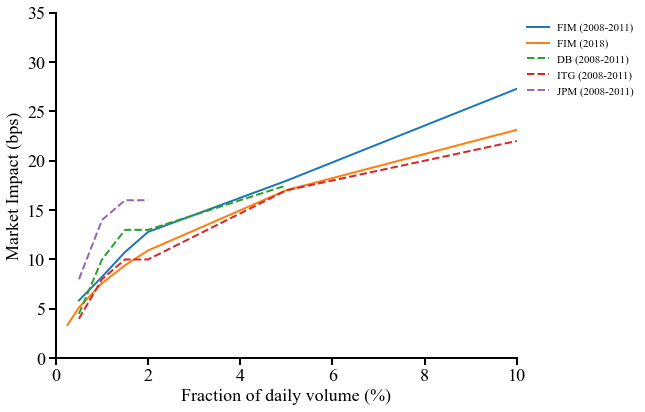

In [72]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pylab import cm

mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
colors = cm.get_cmap('tab20', 10)

# Table X values
fim_estimates = [5.85, 8.24, 10.75, 12.79, 17.97, 27.28]
dtv_values = [0.5, 1.0, 1.5, 2.0, 5.0, 10.0]
fim_model = pd.Series(data = fim_estimates, index = dtv_values, name = "fim_model")

itg_trading_costs = [4, 8, 10, 10, 17, 22]
itg_dtv_values = [0.5, 1.0, 1.5, 2.0, 5.0, 10.0]
itg = pd.Series(data = itg_trading_costs, index = itg_dtv_values, name = "itg")

db_trading_costs = [4.5, 10.0, 13.0, 13.0, 17.5]
db_dtv_values = [0.5, 1.0, 1.5, 2.0, 5.0]
db = pd.Series(data = db_trading_costs, index = db_dtv_values, name = "db")

jpm_trading_costs = [8.0, 14.0, 16.0, 16.0]
jpm_dtv_values = [0.5, 1.0, 1.5, 2.0]
jpm = pd.Series(data = jpm_trading_costs, index = jpm_dtv_values, name = "jpm")

# Plot Market Impact Model Values
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0,0,1,1])
ax.xaxis.set_tick_params(which='both', size=7, width=2, direction='out')
ax.yaxis.set_tick_params(which='both', size=7, width=2, direction='out')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(fim_model, linewidth=2, color=colors(0), label='FIM (2008-2011)')
ax.plot(market_impact_pf.mean(axis=0).iloc[1:], linewidth=2, color=colors(1), label='FIM (2018)')
ax.plot(db, linewidth=2, linestyle='dashed', color=colors(2), label='DB (2008-2011)')
ax.plot(itg, linewidth=2, linestyle='dashed', color=colors(3), label='ITG (2008-2011)')
ax.plot(jpm, linewidth=2, linestyle='dashed', color=colors(4), label='JPM (2008-2011)')
ax.set_xlim(0, 10)
ax.set_ylim(0, 35)
ax.set_xlabel('Fraction of daily volume (%)')
ax.set_ylabel('Market Impact (bps)')
ax.legend(bbox_to_anchor=(1,1), loc=0, frameon=False, fontsize=11)
#plt.savefig('Market Impact Model (2018).png', dpi=300, transparent=False, bbox_inches='tight')

In [73]:
fig.savefig('Market Impact Model (2018).png', dpi=300, transparent=False, bbox_inches='tight')

Figure X shows average realized price impact trading cost across different trade sizes  (% of daily trading volume) from three different brokers: ITG, Deutsche Bank (DB) and JP Morgan (JPM). Six different levels of trade sizes are reported (0.25-0.5% DTV, 0.5-1% DTV, 1-1.5% DTV, 1.5-2% DTV, 2-5% DTV, 5-10% DTV), with a common sample period of these trading costs from 2008-2011. 

Figure X also presents the estimated trading costs from regression specification of AQR's Market Impact Model on the same time period from their live trade database (FIM), as well as the estimated trading costs of our own trades at a different time period (2018), at the same trade sizes.

Actual realized trading costs are marked in solid lines, while estimates are marked in dotted lines, and we observe that the market impact model captures the relationship closely. Most importantly, we observe that the price impact function is concave and not linear as a percentage of the Average Daily Traded Volume. 

This is consistent with literature, which have proposed either concave or lienar relationships between price impact and trade size (Hasbrouck (1991), Hausman, Lo, and MacKinlay (1992), Keim and Madhavan(1995), Almgren (2003) and also the actual trade numbers from brokers: ITG, Deutsche Bank, JP Morgan, AQR. 

The lower trading cost for 2018 trades can be attributed to technological events like moving to decimialization in traded places. There appears to be no evidence of systematic reversal of quote changes after decimalization. Bessembinder (2003). It is also in line with typical trading costs faced by a large instutional investor, as documented in Table A5

Hendrik Bessembinder (2003) - Trade Execution Costs and Market Quality after Decimalization

In [66]:
market_impact_pf.iloc[:,0].mean()

23.12713630970242

Two separate studies using data from ANcerno, a consulting firm that monitors institutional investor execution costs from 750 instutitions executing 104 million trades. The average trade size as a percentage in the two studies is 2.4% DTV, and hence the realized average market impact costs at 2.4% DTV from AQR's own live trade database is also published.

1. ANcerno Database (2008) - 24.5 bps at 2.4% DTV
2. AQR Execution Database (2008) - 18.2bps at 2.4% DTV
3. FIM Model (2018) - 23.12bps at 2.4% DTV

In [68]:
temp_df.to_csv('temp_df.csv', index=False, header=True)

In [71]:
prev_df.to_csv('prev_df.csv', index=False, header=True)